In [1]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt

from utils.utils import load_data, remove_zero_features, load_confounders, deconfound_linear, standardize

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.utils import resample

from sklearn.metrics import average_precision_score, roc_auc_score, brier_score_loss, f1_score, hamming_loss
from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay

In [2]:
plot_path = 'plots/'

In [3]:
N_CORES = joblib.cpu_count(only_physical_cores=True)
print(f"Number of physical cores: {N_CORES}")

Number of physical cores: 8


---

In [4]:
# Load data for classification task
subject_data, features, diagnoses = load_data('classification')

In [5]:
# Remove zero features
F = remove_zero_features(features.iloc[:,1:])

In [6]:
# Load confounders
C = load_confounders(subject_data)

# Apply deconfounding
#F = deconfound_linear(C, F)

In [7]:
# Standardize
X = standardize(F)
print(f"Number of samples: {X.shape[0]}")
print(f"Number of features: {X.shape[1]}")

Number of samples: 2815
Number of features: 922


In [8]:
# Remove ID column
Y = diagnoses.iloc[:,1:]
print(f"Number of labels: {Y.shape[1]}")

Number of labels: 13


In [9]:
# Split dataset into train and test (holdout) set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=0)
print(f"Number of samples in training set: {len(X_train)}")
print(f"Number of samples in test set: {len(X_test)}")

Number of samples in training set: 2111
Number of samples in test set: 704


---

## 1. Multi-label classification
Evaluate separately optimized binary classification models with respect to multi-label performance metrics

### 1.1. Logistic regression

In [10]:
LR_estimators = {}

In [11]:
p_grid_LR = {'C': [0.0001, 0.001, 0.01, 0.1]}

gs_LR = GridSearchCV(
    estimator=LogisticRegression(class_weight='balanced', max_iter=10000, random_state=0),
    param_grid=p_grid_LR,
    scoring='average_precision',
    n_jobs=-1,
    refit=True,
    cv=KFold(n_splits=5, shuffle=True, random_state=0),
    return_train_score=True)

In [12]:
# Perform grid search for every label
for l, label in enumerate(Y.columns):
    y_train = Y_train.iloc[:, l]
    gs_LR.fit(X_train, np.ravel(y_train))

    LR_estimators[label] = gs_LR
    
    print(f"{label}:\n")
    print("AUPRC score (mean cross-validated score of best estimator): {:.2f}". format(float(gs_LR.best_score_)))
    print("Parameters for logistic regression classifier: {}\n".format(gs_LR.best_params_))

Trauma_And_Stress_RelatedDisorders:

AUPRC score (mean cross-validated score of best estimator): 0.10
Parameters for logistic regression classifier: {'C': 0.001}

DepressiveDisorders:

AUPRC score (mean cross-validated score of best estimator): 0.33
Parameters for logistic regression classifier: {'C': 0.0001}

Attention_Deficit_HyperactivityDisorder:

AUPRC score (mean cross-validated score of best estimator): 0.67
Parameters for logistic regression classifier: {'C': 0.0001}

MotorDisorder:

AUPRC score (mean cross-validated score of best estimator): 0.11
Parameters for logistic regression classifier: {'C': 0.1}

AutismSpectrumDisorder:

AUPRC score (mean cross-validated score of best estimator): 0.19
Parameters for logistic regression classifier: {'C': 0.1}

CommunicationDisorder:

AUPRC score (mean cross-validated score of best estimator): 0.23
Parameters for logistic regression classifier: {'C': 0.001}

OtherDisorders:

AUPRC score (mean cross-validated score of best estimator): 0.1

---

In [14]:
# Combined evaluation with respect to multi-label metrics 
auprc_LR = []
auroc_LR = []
brier_LR = []
f1_LR = []
hamm_LR = []

for i in range(100):
    X_test_resampled, y_test_resampled = resample(X_test, Y_test, replace=True, n_samples=len(Y_test), random_state=0+i)

    # Combine prediction probas into single ndarray
    for l, label in enumerate(Y.columns):
        if l == 0:
            Y_prob = LR_estimators[label].predict_proba(X_test_resampled)[:, 1].reshape(-1,1)
            Y_pred = LR_estimators[label].predict(X_test_resampled).reshape(-1,1)
            #print(Y_prob.shape, Y_pred.shape)
        else:
            Y_prob = np.concatenate((Y_prob, LR_estimators[label].predict_proba(X_test_resampled)[:, 1].reshape(-1,1)), axis=1)
            Y_pred = np.concatenate((Y_pred, LR_estimators[label].predict(X_test_resampled).reshape(-1,1)), axis=1)
    
    # Compute brier score
    brier_scores = np.zeros(len(Y.columns))
    for i in range(len(Y.columns)):
        brier_scores[i] = brier_score_loss(y_test_resampled.iloc[:,i], Y_prob[:, i])
    brier_LR.append(brier_scores.mean())

    # Other metrics
    auprc_LR.append(average_precision_score(y_test_resampled, Y_prob, average='macro')) 
    auroc_LR.append(roc_auc_score(y_test_resampled, Y_prob, average='macro'))
    f1_LR.append(f1_score(y_test_resampled, Y_pred, average='micro'))
    hamm_LR.append(hamming_loss(y_test_resampled, Y_pred))

print(f"Mean scores for LR best estimators with 95% confidence intervals:")
print("    AUPRC macro: {:.2f} [{:.2f}, {:.2f}]".format(np.mean(auprc_LR), np.percentile(auprc_LR, 2.5), np.percentile(auprc_LR, 97.5)))
print("    AUROC macro: {:.2f} [{:.2f}, {:.2f}]".format(np.mean(auroc_LR), np.percentile(auroc_LR, 2.5), np.percentile(auroc_LR, 97.5)))
print("    Brier score: {:.2f} [{:.2f}, {:.2f}]".format(np.mean(brier_LR), np.percentile(brier_LR, 2.5), np.percentile(brier_LR, 97.5)))
print("    Hamming loss: {:.2f} [{:.2f}, {:.2f}]".format(np.mean(hamm_LR), np.percentile(hamm_LR, 2.5), np.percentile(hamm_LR, 97.5)))
print("    Micro Avg F1 score: {:.2f} [{:.2f}, {:.2f}]".format(np.mean(f1_LR), np.percentile(f1_LR, 2.5), np.percentile(f1_LR, 97.5)))

Mean scores for LR best estimators with 95% confidence intervals:
    AUPRC macro: 0.20 [0.18, 0.21]
    AUROC macro: 0.54 [0.52, 0.56]
    Brier score: 0.25 [0.25, 0.26]
    Hamming loss: 0.46 [0.44, 0.48]
    Micro Avg F1 score: 0.27 [0.26, 0.29]


### 1.2. SVM

In [15]:
SVC_estimators = {}

In [16]:
p_grid_SVC = {
    'C': [0.01, 0.1, 1, 10],
}

gs_SVC = GridSearchCV(
    estimator=SVC(class_weight='balanced', kernel='rbf', gamma='scale', probability=True, random_state=0),
    param_grid=p_grid_SVC,
    scoring='average_precision',
    n_jobs=-1,
    refit=True,
    cv=KFold(n_splits=5, shuffle=True, random_state=0),
    return_train_score=True)

In [17]:
# Perform grid search for every label
for l, label in enumerate(Y.columns):

    y_train = Y_train.iloc[:, l]
    gs_SVC.fit(X_train, np.ravel(y_train))

    SVC_estimators[label] = gs_SVC
    
    print(f"{label}:\n")
    print("AUPRC score (mean cross-validated score of best estimator): {:.2f}". format(float(gs_SVC.best_score_)))
    print("Parameters for logistic regression classifier: {}\n".format(gs_SVC.best_params_)) 

Trauma_And_Stress_RelatedDisorders:

AUPRC score (mean cross-validated score of best estimator): 0.10
Parameters for logistic regression classifier: {'C': 0.1}

DepressiveDisorders:

AUPRC score (mean cross-validated score of best estimator): 0.35
Parameters for logistic regression classifier: {'C': 0.1}

Attention_Deficit_HyperactivityDisorder:

AUPRC score (mean cross-validated score of best estimator): 0.68
Parameters for logistic regression classifier: {'C': 1}

MotorDisorder:

AUPRC score (mean cross-validated score of best estimator): 0.13
Parameters for logistic regression classifier: {'C': 0.1}

AutismSpectrumDisorder:

AUPRC score (mean cross-validated score of best estimator): 0.20
Parameters for logistic regression classifier: {'C': 1}

CommunicationDisorder:

AUPRC score (mean cross-validated score of best estimator): 0.22
Parameters for logistic regression classifier: {'C': 1}

OtherDisorders:

AUPRC score (mean cross-validated score of best estimator): 0.20
Parameters for

---

In [ ]:
# Combined evaluation with respect to multi-label metrics
auprc_SVM = []
auroc_SVM = []
brier_SVM = []
f1_SVM = []
hamm_SVM = []

for i in range(100):
    X_test_resampled, y_test_resampled = resample(X_test, Y_test, replace=True, n_samples=len(Y_test), random_state=0+i)

     # Combine prediction probas into single ndarray
    for l, label in enumerate(Y.columns):
        if l == 0:
            Y_prob = SVC_estimators[label].predict_proba(X_test_resampled)[:, 1].reshape(-1,1)
            Y_pred = SVC_estimators[label].predict(X_test_resampled).reshape(-1,1)
            #print(Y_prob.shape, Y_pred.shape)
        else:
            Y_prob = np.concatenate((Y_prob, SVC_estimators[label].predict_proba(X_test_resampled)[:, 1].reshape(-1,1)), axis=1)
            Y_pred = np.concatenate((Y_pred, SVC_estimators[label].predict(X_test_resampled).reshape(-1,1)), axis=1)
    
    # Compute brier score
    brier_scores = np.zeros(len(Y.columns))
    for i in range(len(Y.columns)):
        brier_scores[i] = brier_score_loss(y_test_resampled.iloc[:,i], Y_prob[:, i])
    brier_SVM.append(brier_scores.mean())

    # Other metrics
    auprc_SVM.append(average_precision_score(y_test_resampled, Y_prob, average='macro')) 
    auroc_SVM.append(roc_auc_score(y_test_resampled, Y_prob, average='macro'))
    f1_SVM.append(f1_score(y_test_resampled, Y_pred, average='micro'))
    hamm_SVM.append(hamming_loss(y_test_resampled, Y_pred))

print(f"Mean scores for SVM best estimators with 95% confidence intervals:")
print("    AUPRC macro: {:.2f} [{:.2f}, {:.2f}]".format(np.mean(auprc_SVM), np.percentile(auprc_SVM, 2.5), np.percentile(auprc_SVM, 97.5)))
print("    AUROC macro: {:.2f} [{:.2f}, {:.2f}]".format(np.mean(auroc_SVM), np.percentile(auroc_SVM, 2.5), np.percentile(auroc_SVM, 97.5)))
print("    Brier score: {:.2f} [{:.2f}, {:.2f}]".format(np.mean(brier_SVM), np.percentile(brier_SVM, 2.5), np.percentile(brier_SVM, 97.5)))
print("    Hamming loss: {:.2f} [{:.2f}, {:.2f}]".format(np.mean(hamm_SVM), np.percentile(hamm_SVM, 2.5), np.percentile(hamm_SVM, 97.5)))
print("    Micro Avg F1 score: {:.2f} [{:.2f}, {:.2f}]".format(np.mean(f1_SVM), np.percentile(f1_SVM, 2.5), np.percentile(f1_SVM, 97.5)))

### 1.3. Random Forest

In [ ]:
RF_estimators = {}

In [ ]:
p_grid_RF = {'n_estimators': [100, 200, 500, 1000]}

gs_RF = GridSearchCV(
    estimator=RandomForestClassifier(random_state=0),
    param_grid=p_grid_RF,
    scoring='average_precision',
    n_jobs=-1,
    refit=True,
    cv=KFold(n_splits=5, shuffle=True, random_state=0),
    return_train_score=True)

In [ ]:
# Perform grid search for every label
for l, label in enumerate(Y.columns):

    y_train = Y_train.iloc[:, l]
    gs_RF.fit(X_train, np.ravel(y_train))

    RF_estimators[label] = gs_RF
    print(f"{label}:\n")
    
    print("AUPRC score (mean cross-validated score of best estimator): {:.2f}". format(float(gs_RF.best_score_)))
    print("Parameters for logistic regression classifier: {}\n".format(gs_RF.best_params_)) 

Trauma_And_Stress_RelatedDisorders:

AUPRC score (mean cross-validated score of best estimator): 0.06
Parameters for logistic regression classifier: {'n_estimators': 100}

DepressiveDisorders:

AUPRC score (mean cross-validated score of best estimator): 0.30
Parameters for logistic regression classifier: {'n_estimators': 1000}

Attention_Deficit_HyperactivityDisorder:

AUPRC score (mean cross-validated score of best estimator): 0.67
Parameters for logistic regression classifier: {'n_estimators': 1000}

MotorDisorder:

AUPRC score (mean cross-validated score of best estimator): 0.11
Parameters for logistic regression classifier: {'n_estimators': 200}

AutismSpectrumDisorder:

AUPRC score (mean cross-validated score of best estimator): 0.17
Parameters for logistic regression classifier: {'n_estimators': 1000}

CommunicationDisorder:

AUPRC score (mean cross-validated score of best estimator): 0.21
Parameters for logistic regression classifier: {'n_estimators': 500}

OtherDisorders:

AUPR

---

In [ ]:
# Combined evaluation with respect to multi-label metrics
auprc_RF = []
auroc_RF = []
brier_RF = []
f1_RF = []
hamm_RF = []

for i in range(100):
    X_test_resampled, y_test_resampled = resample(X_test, Y_test, replace=True, n_samples=len(Y_test), random_state=0+i)

     # Combine prediction probas into single ndarray
    for l, label in enumerate(Y.columns):
        if l == 0:
            Y_prob = RF_estimators[label].predict_proba(X_test_resampled)[:, 1].reshape(-1,1)
            Y_pred = RF_estimators[label].predict(X_test_resampled).reshape(-1,1)
            #print(Y_prob.shape, Y_pred.shape)
        else:
            Y_prob = np.concatenate((Y_prob, RF_estimators[label].predict_proba(X_test_resampled)[:, 1].reshape(-1,1)), axis=1)
            Y_pred = np.concatenate((Y_pred, RF_estimators[label].predict(X_test_resampled).reshape(-1,1)), axis=1)
    
    # Compute brier score
    brier_scores = np.zeros(len(Y.columns))
    for i in range(len(Y.columns)):
        brier_scores[i] = brier_score_loss(y_test_resampled.iloc[:,i], Y_prob[:, i])
    brier_RF.append(brier_scores.mean())

    # Other metrics
    auprc_RF.append(average_precision_score(y_test_resampled, Y_prob, average='macro')) 
    auroc_RF.append(roc_auc_score(y_test_resampled, Y_prob, average='macro'))
    f1_RF.append(f1_score(y_test_resampled, Y_pred, average='micro'))
    hamm_RF.append(hamming_loss(y_test_resampled, Y_pred))

print(f"Mean scores for RF best estimators with 95% confidence intervals:")
print("    AUPRC macro: {:.2f} [{:.2f}, {:.2f}]".format(np.mean(auprc_RF), np.percentile(auprc_RF, 2.5), np.percentile(auprc_RF, 97.5)))
print("    AUROC macro: {:.2f} [{:.2f}, {:.2f}]".format(np.mean(auroc_RF), np.percentile(auroc_RF, 2.5), np.percentile(auroc_RF, 97.5)))
print("    Brier score: {:.2f} [{:.2f}, {:.2f}]".format(np.mean(brier_RF), np.percentile(brier_RF, 2.5), np.percentile(brier_RF, 97.5)))
print("    Hamming loss: {:.2f} [{:.2f}, {:.2f}]".format(np.mean(hamm_RF), np.percentile(hamm_RF, 2.5), np.percentile(hamm_RF, 97.5)))
print("    Micro Avg F1 score: {:.2f} [{:.2f}, {:.2f}]".format(np.mean(f1_RF), np.percentile(f1_RF, 2.5), np.percentile(f1_RF, 97.5)))

Mean scores for RF best estimators with 95% confidence intervals:
    AUPRC macro: 0.20 [0.19, 0.21]
    AUROC macro: 0.55 [0.53, 0.58]
    Brier score: 0.20 [0.19, 0.20]
    Hamming loss: 0.23 [0.21, 0.25]
    Micro Avg F1 score: 0.14 [0.11, 0.16]


### 1.4. Histogram-based Gradient Boosting

In [ ]:
HGB_estimators = {}

In [ ]:
p_grid_HGB = {
    "learning_rate": [0.01, 0.05, 0.1],
    "max_iter": [100, 200] ,
    "l2_regularization": [0.001, 0.01, 0.1],
}

gs_HGB = GridSearchCV(
    estimator=HistGradientBoostingClassifier(random_state=0),
    param_grid=p_grid_HGB,
    scoring='average_precision',
    n_jobs=-1,
    refit=True,
    cv=KFold(n_splits=5, shuffle=True, random_state=0),
    return_train_score=True)

In [ ]:
# Perform grid search for every label
for l, label in enumerate(Y.columns):

    y_train = Y_train.iloc[:, l]
    gs_HGB.fit(X_train, np.ravel(y_train))

    HGB_estimators[label] = gs_HGB
    print(f"{label}:\n")
    
    print("AUPRC score (mean cross-validated score of best estimator): {:.2f}". format(float(gs_HGB.best_score_)))
    print("Parameters for logistic regression classifier: {}\n".format(gs_HGB.best_params_)) 

Trauma_And_Stress_RelatedDisorders:

AUPRC score (mean cross-validated score of best estimator): 0.11
Parameters for logistic regression classifier: {'l2_regularization': 0.01, 'learning_rate': 0.05, 'max_iter': 200}

DepressiveDisorders:

AUPRC score (mean cross-validated score of best estimator): 0.34
Parameters for logistic regression classifier: {'l2_regularization': 0.01, 'learning_rate': 0.05, 'max_iter': 200}

Attention_Deficit_HyperactivityDisorder:

AUPRC score (mean cross-validated score of best estimator): 0.66
Parameters for logistic regression classifier: {'l2_regularization': 0.1, 'learning_rate': 0.1, 'max_iter': 200}

MotorDisorder:

AUPRC score (mean cross-validated score of best estimator): 0.11
Parameters for logistic regression classifier: {'l2_regularization': 0.1, 'learning_rate': 0.01, 'max_iter': 100}

AutismSpectrumDisorder:

AUPRC score (mean cross-validated score of best estimator): 0.19
Parameters for logistic regression classifier: {'l2_regularization': 0.1

---

In [ ]:
# Combined evaluation with respect to multi-label metrics
auprc_HGB = []
auroc_HGB = []
brier_HGB = []
f1_HGB = []
hamm_HGB = []

for i in range(100):
    X_test_resampled, y_test_resampled = resample(X_test, Y_test, replace=True, n_samples=len(Y_test), random_state=0+i)

     # Combine prediction probas into single ndarray
    for l, label in enumerate(Y.columns):
        if l == 0:
            Y_prob = HGB_estimators[label].predict_proba(X_test_resampled)[:, 1].reshape(-1,1)
            Y_pred = HGB_estimators[label].predict(X_test_resampled).reshape(-1,1)
            #print(Y_prob.shape, Y_pred.shape)
        else:
            Y_prob = np.concatenate((Y_prob, HGB_estimators[label].predict_proba(X_test_resampled)[:, 1].reshape(-1,1)), axis=1)
            Y_pred = np.concatenate((Y_pred, HGB_estimators[label].predict(X_test_resampled).reshape(-1,1)), axis=1)
    
    # Compute brier score
    brier_scores = np.zeros(len(Y.columns))
    for i in range(len(Y.columns)):
        brier_scores[i] = brier_score_loss(y_test_resampled.iloc[:,i], Y_prob[:, i])
    brier_HGB.append(brier_scores.mean())

    # Other metrics
    auprc_HGB.append(average_precision_score(y_test_resampled, Y_prob, average='macro')) 
    auroc_HGB.append(roc_auc_score(y_test_resampled, Y_prob, average='macro'))
    f1_HGB.append(f1_score(y_test_resampled, Y_pred, average='micro'))
    hamm_HGB.append(hamming_loss(y_test_resampled, Y_pred))

print(f"Mean scores for HGB best estimators with 95% confidence intervals:")
print("    AUPRC macro: {:.2f} [{:.2f}, {:.2f}]".format(np.mean(auprc_HGB), np.percentile(auprc_HGB, 2.5), np.percentile(auprc_HGB, 97.5)))
print("    AUROC macro: {:.2f} [{:.2f}, {:.2f}]".format(np.mean(auroc_HGB), np.percentile(auroc_HGB, 2.5), np.percentile(auroc_HGB, 97.5)))
print("    Brier score: {:.2f} [{:.2f}, {:.2f}]".format(np.mean(brier_HGB), np.percentile(brier_HGB, 2.5), np.percentile(brier_HGB, 97.5)))
print("    Hamming loss: {:.2f} [{:.2f}, {:.2f}]".format(np.mean(hamm_HGB), np.percentile(hamm_HGB, 2.5), np.percentile(hamm_HGB, 97.5)))
print("    Micro Avg F1 score: {:.2f} [{:.2f}, {:.2f}]".format(np.mean(f1_HGB), np.percentile(f1_HGB, 2.5), np.percentile(f1_HGB, 97.5)))

Mean scores for HGB best estimators with 95% confidence intervals:
    AUPRC macro: 0.20 [0.18, 0.21]
    AUROC macro: 0.52 [0.50, 0.55]
    Brier score: 0.19 [0.19, 0.20]
    Hamming loss: 0.27 [0.25, 0.29]
    Micro Avg F1 score: 0.20 [0.17, 0.23]


### 1.5 MLP

In [ ]:
MLP_estimators = {}

In [ ]:
p_grid_MLP = {
    "hidden_layer_sizes": [(512, 128, 64), (256, 128, 64, 32)],
    "alpha": [0.0001, 0.001],
}

gs_MLP = GridSearchCV(
    estimator=MLPClassifier(random_state=0),
    param_grid=p_grid_MLP,
    scoring='average_precision',
    n_jobs=-1,
    refit=True,
    cv=KFold(n_splits=5, shuffle=True, random_state=0),
    return_train_score=True)

In [ ]:
# Perform grid search for every label
for l, label in enumerate(Y.columns):

    y_train = Y_train.iloc[:, l]
    gs_MLP.fit(X_train, np.ravel(y_train))

    MLP_estimators[label] = gs_MLP
    print(f"{label}:\n")
    
    print("AUPRC score (mean cross-validated score of best estimator): {:.2f}". format(float(gs_MLP.best_score_)))
    print("Parameters for logistic regression classifier: {}\n".format(gs_MLP.best_params_)) 

Trauma_And_Stress_RelatedDisorders:

AUPRC score (mean cross-validated score of best estimator): 0.09
Parameters for logistic regression classifier: {'alpha': 0.001, 'hidden_layer_sizes': (512, 128, 64)}

DepressiveDisorders:

AUPRC score (mean cross-validated score of best estimator): 0.27
Parameters for logistic regression classifier: {'alpha': 0.0001, 'hidden_layer_sizes': (512, 128, 64)}

Attention_Deficit_HyperactivityDisorder:

AUPRC score (mean cross-validated score of best estimator): 0.69
Parameters for logistic regression classifier: {'alpha': 0.001, 'hidden_layer_sizes': (512, 128, 64)}

MotorDisorder:

AUPRC score (mean cross-validated score of best estimator): 0.10
Parameters for logistic regression classifier: {'alpha': 0.001, 'hidden_layer_sizes': (512, 128, 64)}

AutismSpectrumDisorder:

AUPRC score (mean cross-validated score of best estimator): 0.19
Parameters for logistic regression classifier: {'alpha': 0.0001, 'hidden_layer_sizes': (256, 128, 64, 32)}

Communicatio

In [ ]:
# Combined evaluation with respect to multi-label metrics
auprc_MLP = []
auroc_MLP = []
brier_MLP = []
f1_MLP = []
hamm_MLP = []

for i in range(100):
    X_test_resampled, y_test_resampled = resample(X_test, Y_test, replace=True, n_samples=len(Y_test), random_state=0+i)

     # Combine prediction probas into single ndarray
    for l, label in enumerate(Y.columns):
        if l == 0:
            Y_prob = MLP_estimators[label].predict_proba(X_test_resampled)[:, 1].reshape(-1,1)
            Y_pred = MLP_estimators[label].predict(X_test_resampled).reshape(-1,1)
            #print(Y_prob.shape, Y_pred.shape)
        else:
            Y_prob = np.concatenate((Y_prob, MLP_estimators[label].predict_proba(X_test_resampled)[:, 1].reshape(-1,1)), axis=1)
            Y_pred = np.concatenate((Y_pred, MLP_estimators[label].predict(X_test_resampled).reshape(-1,1)), axis=1)
    
    # Compute brier score
    brier_scores = np.zeros(len(Y.columns))
    for i in range(len(Y.columns)):
        brier_scores[i] = brier_score_loss(y_test_resampled.iloc[:,i], Y_prob[:, i])
    brier_MLP.append(brier_scores.mean())

    # Other metrics
    auprc_MLP.append(average_precision_score(y_test_resampled, Y_prob, average='macro')) 
    auroc_MLP.append(roc_auc_score(y_test_resampled, Y_prob, average='macro'))
    f1_MLP.append(f1_score(y_test_resampled, Y_pred, average='micro'))
    hamm_MLP.append(hamming_loss(y_test_resampled, Y_pred))

print(f"Mean scores for MLP best estimators with 95% confidence intervals:")
print("    AUPRC macro: {:.2f} [{:.2f}, {:.2f}]".format(np.mean(auprc_MLP), np.percentile(auprc_MLP, 2.5), np.percentile(auprc_MLP, 97.5)))
print("    AUROC macro: {:.2f} [{:.2f}, {:.2f}]".format(np.mean(auroc_MLP), np.percentile(auroc_MLP, 2.5), np.percentile(auroc_MLP, 97.5)))
print("    Brier score: {:.2f} [{:.2f}, {:.2f}]".format(np.mean(brier_MLP), np.percentile(brier_MLP, 2.5), np.percentile(brier_MLP, 97.5)))
print("    Hamming loss: {:.2f} [{:.2f}, {:.2f}]".format(np.mean(hamm_MLP), np.percentile(hamm_MLP, 2.5), np.percentile(hamm_MLP, 97.5)))
print("    Micro Avg F1 score: {:.2f} [{:.2f}, {:.2f}]".format(np.mean(f1_MLP), np.percentile(f1_MLP, 2.5), np.percentile(f1_MLP, 97.5)))

Mean scores for MLP best estimators with 95% confidence intervals:
    AUPRC macro: 0.19 [0.17, 0.21]
    AUROC macro: 0.52 [0.50, 0.55]
    Brier score: 0.32 [0.30, 0.34]
    Hamming loss: 0.37 [0.34, 0.39]
    Micro Avg F1 score: 0.22 [0.20, 0.25]


## 2. Plot PR and roc curves

### 2.1. PR curve

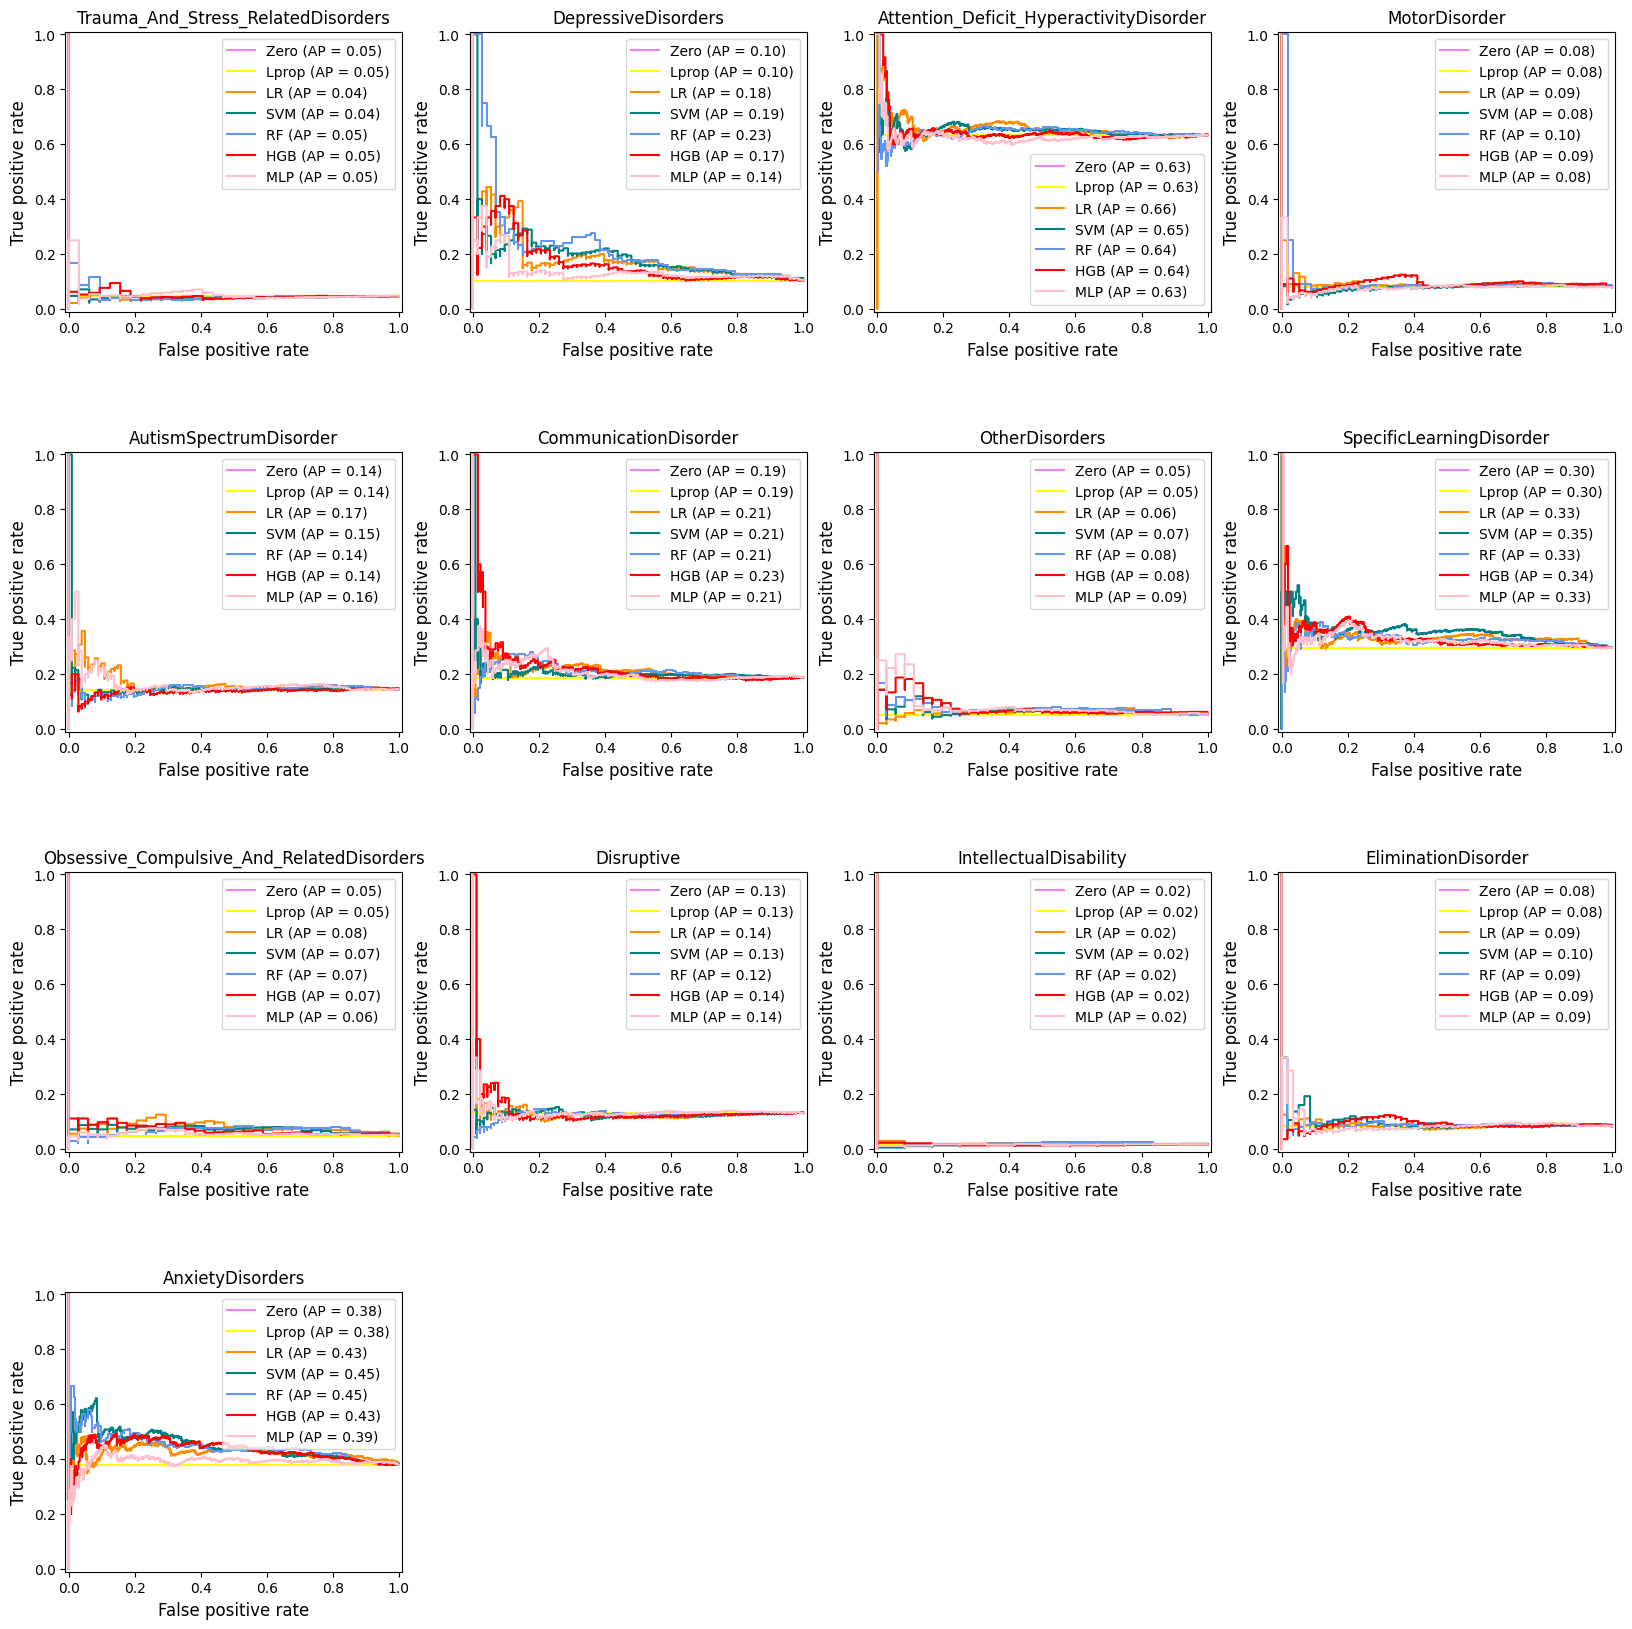

In [ ]:
fig, axs = plt.subplots(4,4, figsize=(20, 20))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)

counter = 0
for i in range(0,4,1):
    for j in range(0,4,1):
        if (i > 2 & j > 0) or (counter > 12):
            fig.delaxes(axs[i,j])
        else:
            label = Y_test.columns[counter]
            counter += 1
            
            zero_baseline_clf = DummyClassifier(strategy='constant', random_state=0, constant=0).fit(X_train, Y_train[label])
            lprop_baseline_clf = DummyClassifier(strategy='prior', random_state=0).fit(X_train, Y_train[label])

            y_score_zero_baseline = zero_baseline_clf.predict_proba(X_test)[:, 1] # Zero baseline
            y_score_lprop_baseline = lprop_baseline_clf.predict_proba(X_test)[:, 1] # Label proportional baseline
            y_score_LR = LR_estimators[label].predict_proba(X_test)[:, 1] # Logistic regression
            y_score_SVM = SVC_estimators[label].predict_proba(X_test)[:, 1] # SVM
            y_score_RF = RF_estimators[label].predict_proba(X_test)[:, 1] # Random forest
            y_score_HGB = HGB_estimators[label].predict_proba(X_test)[:, 1] # Histogram gradient boosting
            y_score_MLP = MLP_estimators[label].predict_proba(X_test)[:, 1] # MLP
            
            disp1 = PrecisionRecallDisplay.from_predictions(Y_test[label], y_score_zero_baseline, pos_label=1, name="Zero", ax=axs[i,j], color="violet")
            disp2 = PrecisionRecallDisplay.from_predictions(Y_test[label], y_score_lprop_baseline, pos_label=1, name="Lprop", ax=axs[i,j], color="yellow")
            disp3 = PrecisionRecallDisplay.from_predictions(Y_test[label], y_score_LR, pos_label=1, name="LR", ax=axs[i,j], color="darkorange")
            disp4 = PrecisionRecallDisplay.from_predictions(Y_test[label], y_score_SVM, pos_label=1, name="SVM", ax=axs[i,j], color="teal")
            disp5 = PrecisionRecallDisplay.from_predictions(Y_test[label], y_score_RF, pos_label=1, name="RF", ax=axs[i,j], color="cornflowerblue")
            disp6 = PrecisionRecallDisplay.from_predictions(Y_test[label], y_score_HGB, pos_label=1, name="HGB", ax=axs[i,j], color="red")
            disp7 = PrecisionRecallDisplay.from_predictions(Y_test[label], y_score_MLP, pos_label=1, name="MLP", ax=axs[i,j], color="pink")
            
            axs[i,j].set_title(f"{label}")
            axs[i,j].legend(loc="best")
            axs[i,j].set_xlabel("False positive rate", size=12)
            axs[i,j].set_ylabel("True positive rate", size=12)
            axs[i,j].set_xmargin(0.01)
            axs[i,j].set_ymargin(0.01)

### 2.2. Roc curve

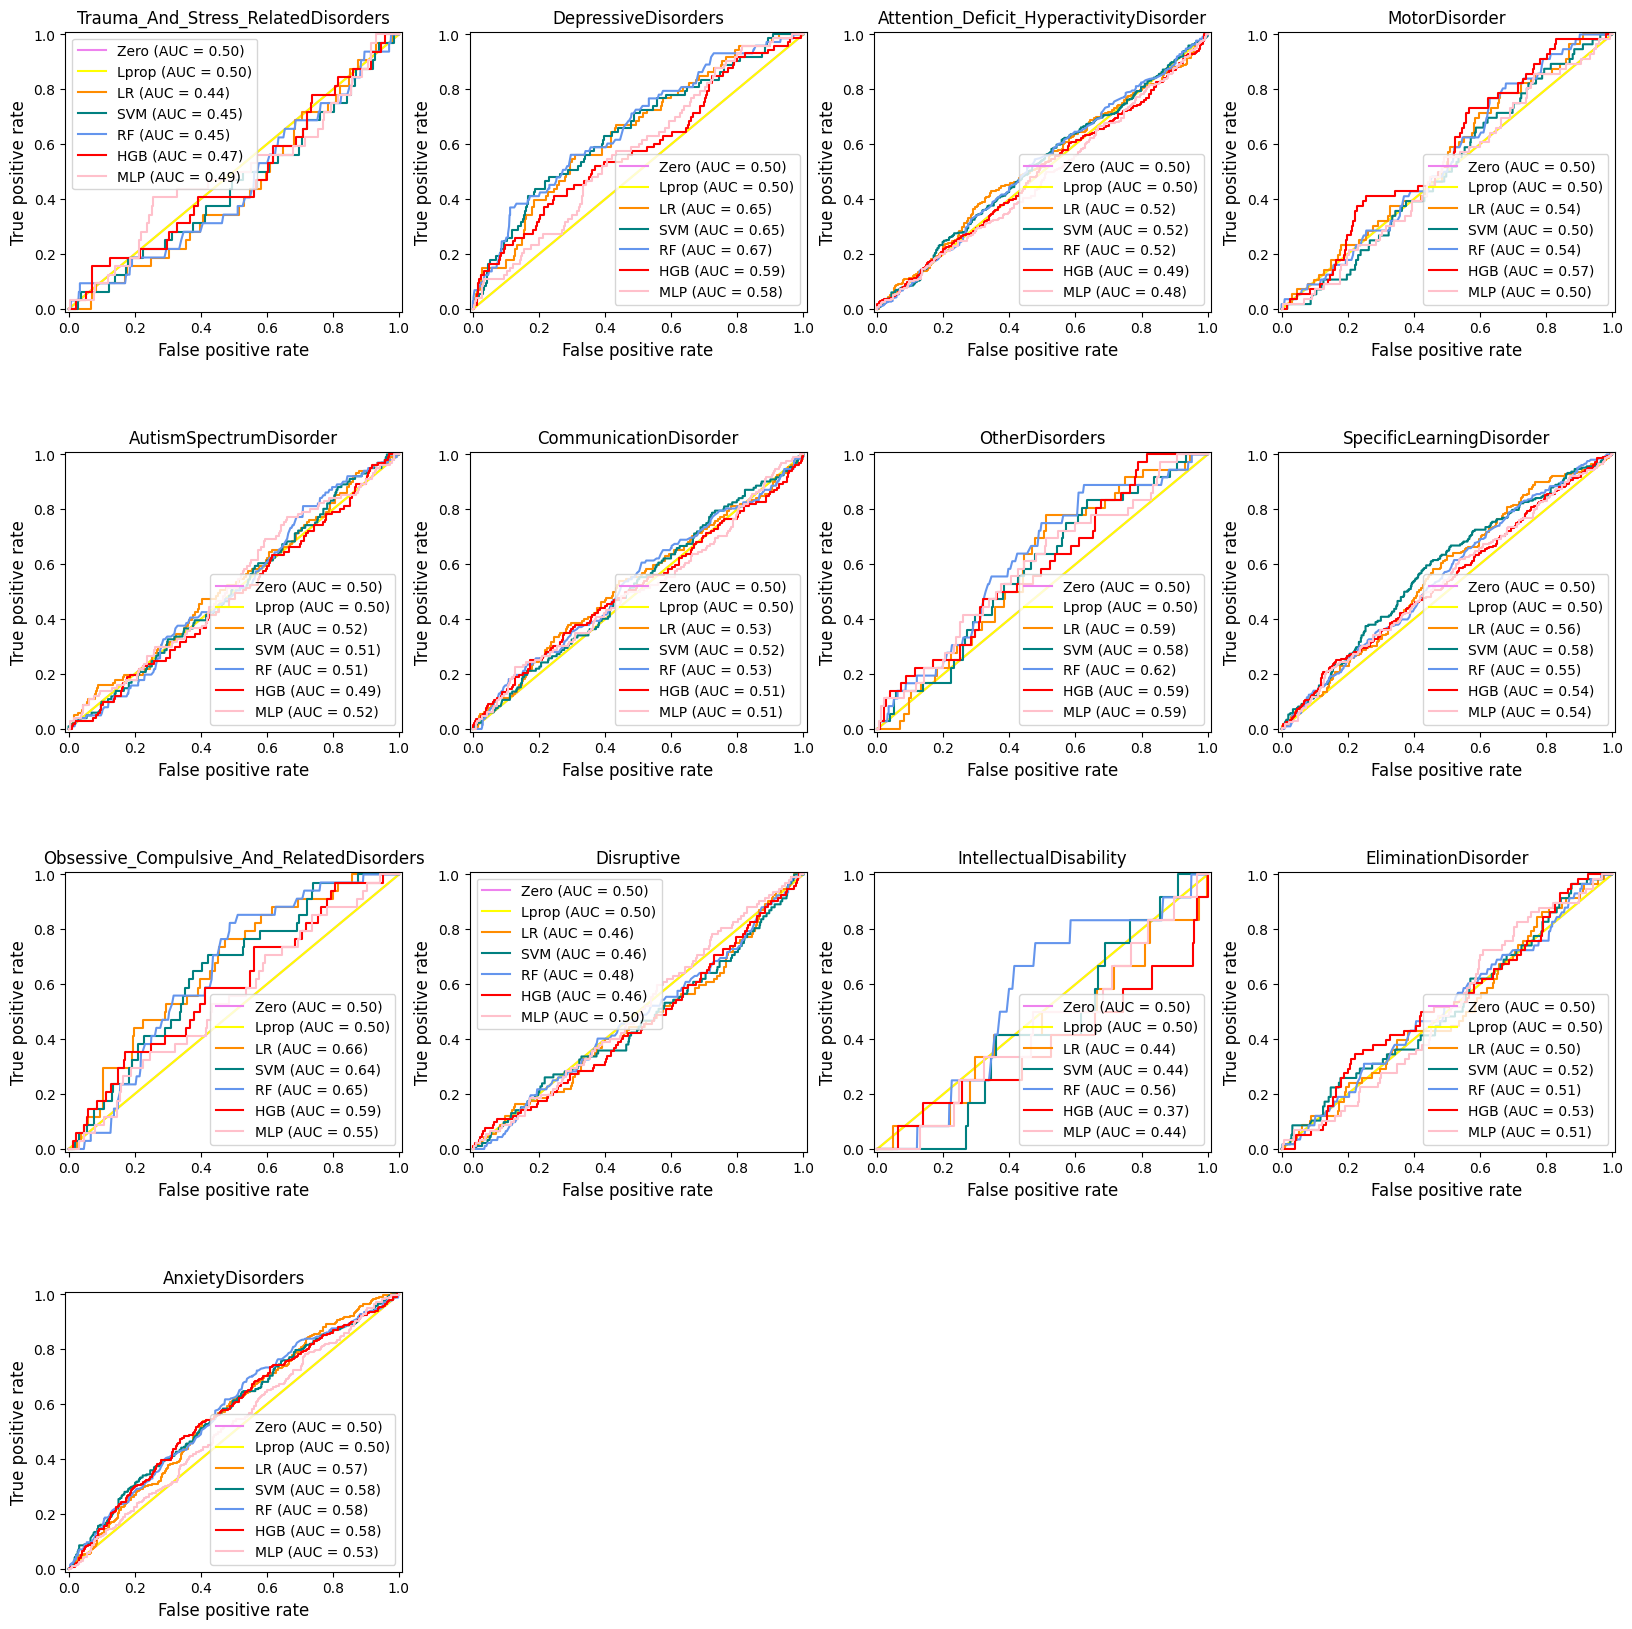

In [ ]:
fig, axs = plt.subplots(4,4, figsize=(20, 20))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)

counter = 0
for i in range(0,4,1):
    for j in range(0,4,1):
        if (i > 2 & j > 0) or (counter > 12):
            fig.delaxes(axs[i,j])
        else:
            label = Y_test.columns[counter]
            counter += 1
            
            zero_baseline_clf = DummyClassifier(strategy='constant', random_state=0, constant=0).fit(X_train, Y_train[label])
            lprop_baseline_clf = DummyClassifier(strategy='prior', random_state=0).fit(X_train, Y_train[label])

            y_score_zero_baseline = zero_baseline_clf.predict_proba(X_test)[:, 1] # Zero baseline
            y_score_lprop_baseline = lprop_baseline_clf.predict_proba(X_test)[:, 1] # Label proportional baseline
            y_score_LR = LR_estimators[label].predict_proba(X_test)[:, 1] # Logistic regression
            y_score_SVM = SVC_estimators[label].predict_proba(X_test)[:, 1] # SVM
            y_score_RF = RF_estimators[label].predict_proba(X_test)[:, 1] # Random forest
            y_score_HGB = HGB_estimators[label].predict_proba(X_test)[:, 1] # Histogram gradient boosting
            y_score_MLP = MLP_estimators[label].predict_proba(X_test)[:, 1] # MLP
            
            disp1 = RocCurveDisplay.from_predictions(Y_test[label], y_score_zero_baseline, pos_label=1, name="Zero", ax=axs[i,j], color="violet")
            disp2 = RocCurveDisplay.from_predictions(Y_test[label], y_score_lprop_baseline, pos_label=1, name="Lprop", ax=axs[i,j], color="yellow")
            disp3 = RocCurveDisplay.from_predictions(Y_test[label], y_score_LR, pos_label=1, name="LR", ax=axs[i,j], color="darkorange")
            disp4 = RocCurveDisplay.from_predictions(Y_test[label], y_score_SVM, pos_label=1, name="SVM", ax=axs[i,j], color="teal")
            disp5 = RocCurveDisplay.from_predictions(Y_test[label], y_score_RF, pos_label=1, name="RF", ax=axs[i,j], color="cornflowerblue")
            disp6 = RocCurveDisplay.from_predictions(Y_test[label], y_score_HGB, pos_label=1, name="HGB", ax=axs[i,j], color="red")
            disp7 = RocCurveDisplay.from_predictions(Y_test[label], y_score_MLP, pos_label=1, name="MLP", ax=axs[i,j], color="pink")

            axs[i,j].set_title(f"{label}")
            axs[i,j].legend(loc="best")
            axs[i,j].set_xlabel("False positive rate", size=12)
            axs[i,j].set_ylabel("True positive rate", size=12)
            axs[i,j].set_xmargin(0.01)
            axs[i,j].set_ymargin(0.01)